This is a note to reproduce work from https://arxiv.org/pdf/1107.1772.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as sciopt

In [2]:
from tmm import guided_mode_te, populate_mode_te, populate_layer_var

In [3]:
ACTIVE_EPS = 12.8603
GAAS_EPS = 12.7449
AIR_EPS = 1.0
N_CLAD_EPS = 11.0224
P_CLAD_EPS=11.0224

ACTIVE_SIZE = 0.3
GAAS_SIZE = 0.2
PC_SIZE = 0.4

Construct unit cell with triangle hole

In [90]:
CELL_N = 300
unit_axis = np.linspace(0, 1, CELL_N, endpoint=False)
coord_x, coord_y = np.meshgrid(unit_axis, unit_axis)

In [99]:
# Triangle
triangle_size = 0.63
assert triangle_size < 1.0
fill = coord_x + coord_y >= triangle_size
# Circle
circle_size = 0.504
assert circle_size < 1.0
fill = (coord_x - 0.5)**2 + (coord_y - 0.5)**2 >= (circle_size/2)**2

In [100]:
pc_eps_pixel = AIR_EPS + (GAAS_EPS - AIR_EPS) * fill
pc_eps = np.mean(pc_eps_pixel)
fill_factor = 1 - np.sum(fill) / (CELL_N * CELL_N)
print("filling factor: ", fill_factor)

filling factor:  0.19938888888888884


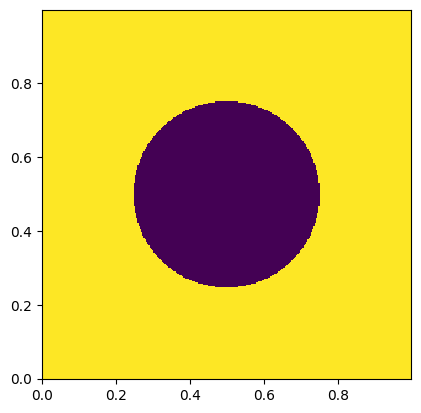

In [101]:
plt.pcolor(coord_x, coord_y, pc_eps_pixel)
plt.gca().set_aspect('equal')

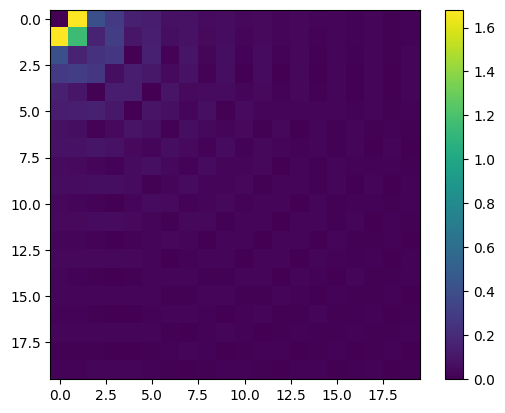

In [102]:
eps_fft = np.fft.rfft2(pc_eps_pixel - pc_eps) / CELL_N**2
cutoff_freq = 20
eps_fft_abs = np.abs(eps_fft)
p = plt.imshow(eps_fft_abs[:cutoff_freq, :cutoff_freq], vmax=np.max(eps_fft_abs))
plt.colorbar(p)

Solve for guided mode in slab, assumming no PhC structure, using the transfer matrix method

In [6]:
layer_width = np.array([ACTIVE_SIZE, PC_SIZE, GAAS_SIZE])
layer_eps = np.array([N_CLAD_EPS, ACTIVE_EPS, pc_eps, GAAS_EPS, P_CLAD_EPS])

In [7]:
# Test the guided_mode_te function
beta = 2 * np.pi
k0 = guided_mode_te(layer_width, layer_eps, beta)
print(f"{k0=}")

k0=1.8734570258563676


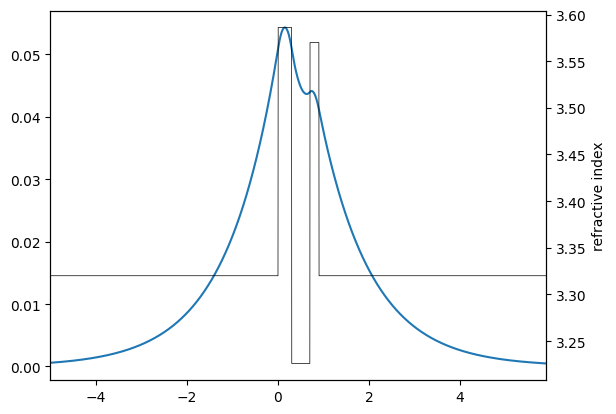

In [8]:

padding = 5.0
z_min = -padding
z_max = sum(layer_width) + padding
z = np.linspace(z_min, z_max, 5000)
plt.plot(z, populate_mode_te(z, k0, beta, layer_width, layer_eps))
plt.xlim(z_min, z_max)
# plt.ylim(0)
ref_idx_ax = plt.gca().twinx()
ref_idx_ax.plot(z, populate_layer_var(z, layer_width, np.sqrt(layer_eps)), 'k', lw=0.5)
_ = ref_idx_ax.set_ylabel("refractive index")


Not included in the paper but the slab with no PhC is the basis to start the perturbation, whose dispersion relation is:

In [9]:
betas = np.linspace(0.01, 4 * np.pi, 100)
# betas = np.linspace(0.01, 30, 500)
k0s = np.array([guided_mode_te(layer_width, layer_eps, beta) for beta in betas])

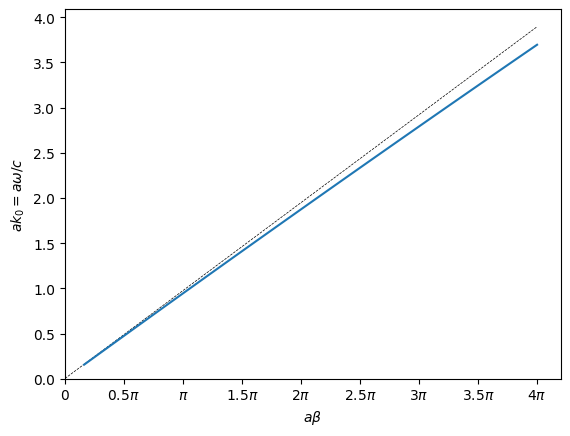

In [10]:
min_traveling_n = min(np.sqrt(layer_eps[0:-1]))
plt.plot(betas, betas / min_traveling_n, 'k--', lw=0.5)
plt.plot(betas, k0s)
plt.xlim(0)
plt.ylim(0)
plt.ylabel(r"$ak_0 = a\omega / c$")
_ = plt.xlabel(r"$a\beta$")
_ = plt.xticks(np.pi * np.arange(0, 4.5, 0.5),
           ["0", r"$0.5\pi$", r"$\pi$", r"$1.5\pi$", r"$2\pi$",
           r"$2.5\pi$", r"$3\pi$", r"$3.5\pi$", r"$4\pi$"])

In the following context we call the above curve $\omega_b(\beta) = ck_0(\beta)$.

Equivalently if we pretend there is a unit cell (although constant) with size $a$, the dispersion/band diagram of the first Brillouin zone:

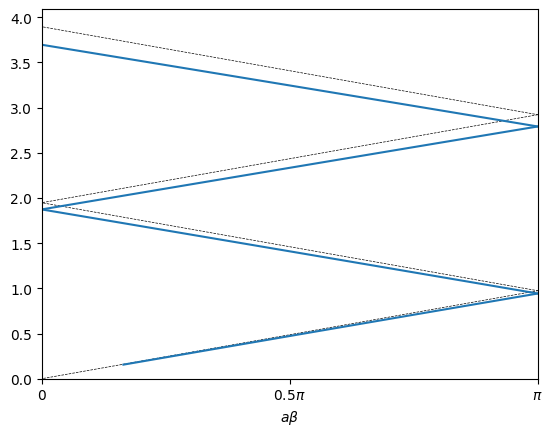

In [11]:
plt.plot(betas, betas / min_traveling_n, 'k--', lw=0.5)
plt.plot(2*np.pi-betas, betas / min_traveling_n, 'k--', lw=0.5)
plt.plot(betas-2*np.pi, betas / min_traveling_n, 'k--', lw=0.5)
plt.plot(4*np.pi-betas, betas / min_traveling_n, 'k--', lw=0.5)

plt.plot(betas, k0s, 'C0')
plt.plot(2*np.pi - betas, k0s, 'C0')
plt.plot(betas - 2*np.pi, k0s, 'C0')
plt.plot(4*np.pi - betas, k0s, 'C0')
plt.xlim(0, np.pi)
plt.ylim(0)
_ = plt.xlabel(r"$a\beta$")
_ = plt.xticks([0, np.pi/2, np.pi], ["0", r"$0.5\pi$", r"$\pi$"])

The CWT is essentially perturbation around $\beta = 2\pi / a$

The radiation mode is the non-bounded mode at $\beta =0$ 

> Not included in the paper but it can and should also include other radiated $k=2m\pi$ ($m=1, 2, \cdots$)?

Yes, but the rediated wave has frequency $\omega \ge 2m\pi / (n_\text{env} a)$ (above the dashed black line in the dispersion diagram) which if off-resonance with $\omega_b(2m\pi / a)$ 